# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from time import time
import os
import random

!pip install progressbar
!pip install xgboost

import progressbar

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.preprocessing import Imputer

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor


from sklearn import metrics
from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score


from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN, MeanShift

import xgboost as xgb
from xgboost.sklearn import XGBRegressor 



# magic word for producing visualizations in notebook
%matplotlib inline
%config InlineBachend.figure_format = 'retina'

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar
    100% |████████████████████████████████| 109.8MB 347kB/s eta 0:00:01 0% |▎                               | 952kB 10.9MB/s eta 0:00:10    3% |█▏                              | 3.9MB 28.3MB/s eta 0:00:04    9% |███                             | 10.0MB 30.3MB/s eta 0:00:04    10% |███▍                            | 11.5MB 31.9MB/s eta 0:00:04    14% |████▋                           | 15.9MB 32.3MB/s eta 0:00:03    19% |██████▍                         | 21.8MB 27.5MB/s eta 0:00:04    24% |████████                        | 27.4MB 22.4MB/s eta 0:00:04    26% |████████▍                       | 28.8MB 29.3MB/s eta 0:00:03    27% |████████▉                       | 30.2MB 30.5MB/s eta 0:00:03    34% |███████████                     | 37.4MB 26.8MB/s eta 0:00:03    37% |████████████                    | 

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Make a copy of original DataFrams to compare the performance or further use:

In [3]:
azdias_copy = azdias.copy()
customers_copy = customers.copy()
azdias = azdias_copy
customers = customers_copy

# Exploratory Data Analysis

In [4]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


### Missing Values

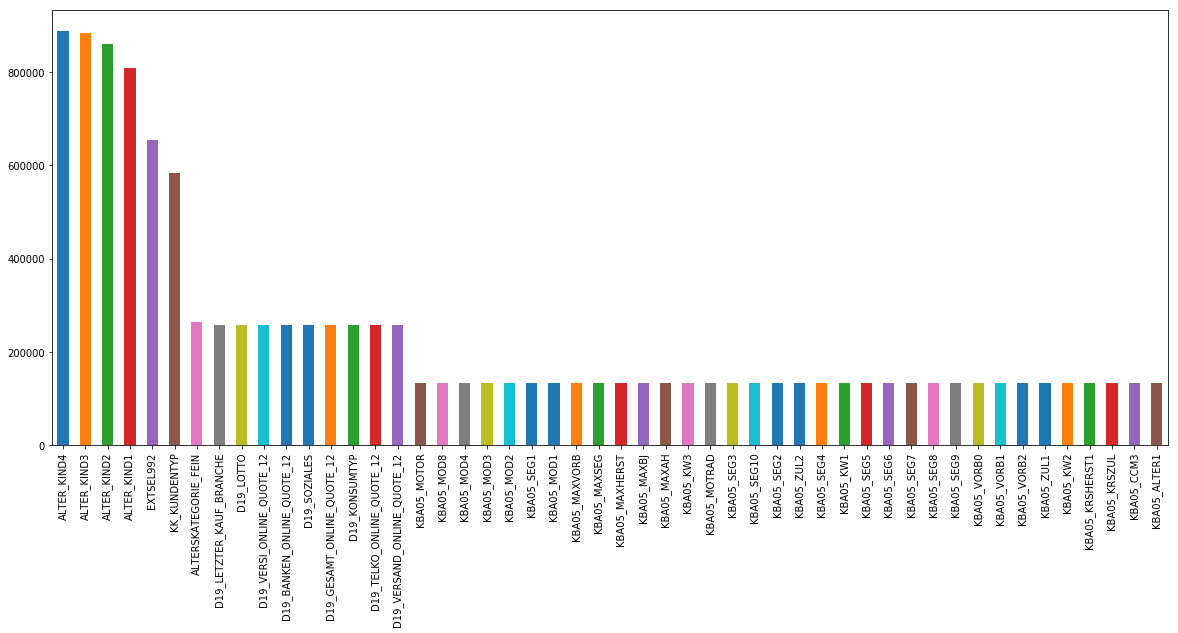

In [5]:
# Total Missing Values
missing_azdias_sum = azdias.isnull().sum()
missing_azdias_prcnt = azdias.isnull().mean()

# Visualize missing values
missing_azdias_sum.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8))

In [6]:
# % of missing data in columns 
print("% of missing data in columns", "\n", missing_azdias_prcnt.sort_values(ascending=False))

% of missing data in columns 
 ALTER_KIND4                    0.998648
ALTER_KIND3                    0.993077
ALTER_KIND2                    0.966900
ALTER_KIND1                    0.909048
EXTSEL992                      0.733996
KK_KUNDENTYP                   0.655967
ALTERSKATEGORIE_FEIN           0.295041
D19_LETZTER_KAUF_BRANCHE       0.288495
D19_LOTTO                      0.288495
D19_VERSI_ONLINE_QUOTE_12      0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_SOZIALES                   0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_KONSUMTYP                  0.288495
D19_TELKO_ONLINE_QUOTE_12      0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
KBA05_MOTOR                    0.149597
KBA05_MOD8                     0.149597
KBA05_MOD4                     0.149597
KBA05_MOD3                     0.149597
KBA05_MOD2                     0.149597
KBA05_SEG1                     0.149597
KBA05_MOD1                     0.149597
KBA05_MAXVORB                  0.149597
KBA05_MAX

Text(0.5,0,'Proportion of Missing Values')

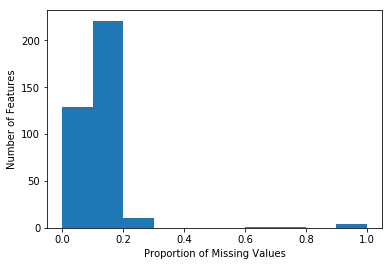

In [7]:
# Visualize the missing tend
plt.hist(missing_azdias_prcnt)
plt.ylabel("Number of Features")
plt.xlabel("Proportion of Missing Values")

In [8]:
# Numbers of features in %
print("Columns having missing values > 0% :  ", len(missing_azdias_prcnt[missing_azdias_prcnt > 0].index))
print("Columns having missing values > 10% :  ", len(missing_azdias_prcnt[missing_azdias_prcnt > .10].index))
print("Columns having missing values > 20% :  ", len(missing_azdias_prcnt[missing_azdias_prcnt > .20].index))
print("Columns having missing values > 30% :  ", len(missing_azdias_prcnt[missing_azdias_prcnt > .30].index))
print("Columns having missing values > 40% :  ", len(missing_azdias_prcnt[missing_azdias_prcnt > .40].index))
print("Columns having missing values > 50% :  ", len(missing_azdias_prcnt[missing_azdias_prcnt > .50].index))
print("Columns having missing values > 60% :  ", len(missing_azdias_prcnt[missing_azdias_prcnt > .60].index))
print("Columns having missing values > 70% :  ", len(missing_azdias_prcnt[missing_azdias_prcnt > .70].index))
print("Columns having missing values > 80% :  ", len(missing_azdias_prcnt[missing_azdias_prcnt > .80].index))
print("Columns having missing values > 90% :  ", len(missing_azdias_prcnt[missing_azdias_prcnt > .90].index))

Columns having missing values > 0% :   273
Columns having missing values > 10% :   237
Columns having missing values > 20% :   16
Columns having missing values > 30% :   6
Columns having missing values > 40% :   6
Columns having missing values > 50% :   6
Columns having missing values > 60% :   6
Columns having missing values > 70% :   5
Columns having missing values > 80% :   4
Columns having missing values > 90% :   4


Text(0.5,0,'# of missing values')

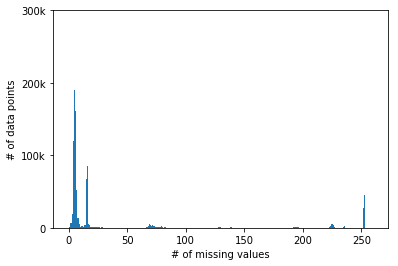

In [9]:
row_nans = azdias.isnull().sum(axis=1)
plt.hist(row_nans, bins = np.arange(-0.5, row_nans.max()+1, 1))
plt.yticks(np.arange(0,300000+100000,100000),['0','100k','200k','300k'])
plt.ylabel('# of data points')
plt.xlabel('# of missing values')

Text(0.5,0,'# of missing values')

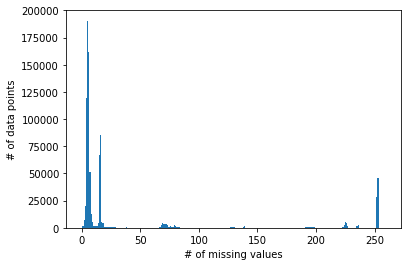

In [10]:
row_nans = azdias[azdias.isnull().sum(axis=1) > 0].isnull().sum(axis=1)
plt.hist(row_nans, bins = np.arange(-0.5,row_nans.max()+1,1))
plt.ylabel('# of data points')
plt.xlabel('# of missing values')

# Data Preprocessing

In [11]:
def data_preprocess(df, for_clustering, df_name=None):
    """Preform data preprocessing steps such as missing value handeling and Feature Engineering for clustering and furter
    analysis of this project.
    
    Params:
    df: The DataFrame
    for_clustering: True
    df_name: The name of the DataFramne.
    
    Return: Trimmed and cleaned DataFramne.
    """
    
    if for_clustering:
        if df_name == 'azdias':
            df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)
        elif df_name == 'customers':            
            df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    #column_nans = df.isnull().mean()
    drop_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP']
    
    df = df.drop(drop_cols,axis=1)
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)


    # find correlation matrix    
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # identify columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
    # drop columns from df
    df = df.drop(drop_columns, axis=1)
    print('shape after corr', df.shape)


    # we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']]=df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)



    # fillna with 9 for fields that has 9 marked as unknown
    df[df.columns[(df==9).any()]] = df[df.columns[(df==9).any()]].fillna(9)

    # fillna with 0 for fields that has 0 marked as unknown
    df[df.columns[(df==0).any()]] = df[df.columns[(df==0).any()]].fillna(0)

    # fillna with -1 for fields that has 0 marked as unknown
    df[df.columns[(df==-1).any()]] = df[df.columns[(df==-1).any()]].fillna(-1)


    
    #print('col name before: ', df.columns)
    #with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding
    df = pd.get_dummies(df)
    #print('col name after: ', df.columns)
    print('shape after one-hot', df.shape)
    
    df_columns = list(df.columns.values)

    # impute nans using mode value
    imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df)
    #print('imputed dataframe: ', df.head(5))
    print('shape after impute', df.shape)
    
    
    
    # convert to int
    df = df.astype(int)


    # detect and exclude outliers in dataframe
    # as mentioned in https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    #  remove all rows that have outliers in at least one column   
    if for_clustering:
        print('inside outliers if')
        df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)] 
        print('shape before scaling', df.shape)
    # scale the data
    scale = StandardScaler(copy=False)
    scaled = scale.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    print('shape after scaling', df.shape)
    #else:
    #    df.columns = df_columns
        
    df = df.set_index('LNR')
    return df


### Clean azdias- General Population dataset

In [12]:
azdias = data_preprocess(azdias, True, 'azdias')
print(azdias.shape)
print(azdias.head(5))

shape after corr (733227, 238)
shape after one-hot (733227, 284)
shape after impute (733227, 284)
inside outliers if
shape before scaling (415405, 284)
shape after scaling (415405, 284)
(415405, 283)
          AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
LNR                                                              
1.044527 -0.549413    1.155132  0.831893              0.911269   
1.044589 -0.549413   -1.017213  1.223909              0.285868   
1.044600  2.747309   -1.017213 -0.082810             -0.547999   
1.044616 -0.549413    1.155132 -1.389529             -0.756466   
1.044666 -0.549413   -1.017213  0.439878              0.285868   

          ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
LNR                                                                     
1.044527             0.170790     -0.142864   -0.281792     -0.610158   
1.044589            -0.488492     -0.142864   -0.281792      2.240974   
1.044600            -0.300126     -0.142864  

### Clean customers dataset

In [13]:
customers = data_preprocess(customers, True, 'customers')
print(customers.shape)
print(customers.head(5))

shape after corr (191652, 256)
shape after one-hot (191652, 303)
shape after impute (191652, 303)
inside outliers if
shape before scaling (100341, 303)
shape after scaling (100341, 303)
(100341, 302)
           AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
LNR                                                               
-1.556361 -0.738505    1.010105  0.168897             -0.209002   
 0.872952  0.777112   -1.037635 -0.468300             -0.545546   
 0.873622  0.777112   -1.037635 -0.043502             -0.209002   
 0.118344  0.777112   -1.037635  2.080488              1.137176   
 0.118561  0.777112   -1.037635 -0.043502              0.127543   

           ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
LNR                                                                      
-1.556361             0.808794      0.992832   -0.193253     -0.686881   
 0.872952            -1.330334      0.992832   -0.193253     -1.545501   
 0.873622            -1.092653    

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

Now we will be using Principal Component Analysis to reduce the dimension of out dataset.

### Choosing the number of components¶


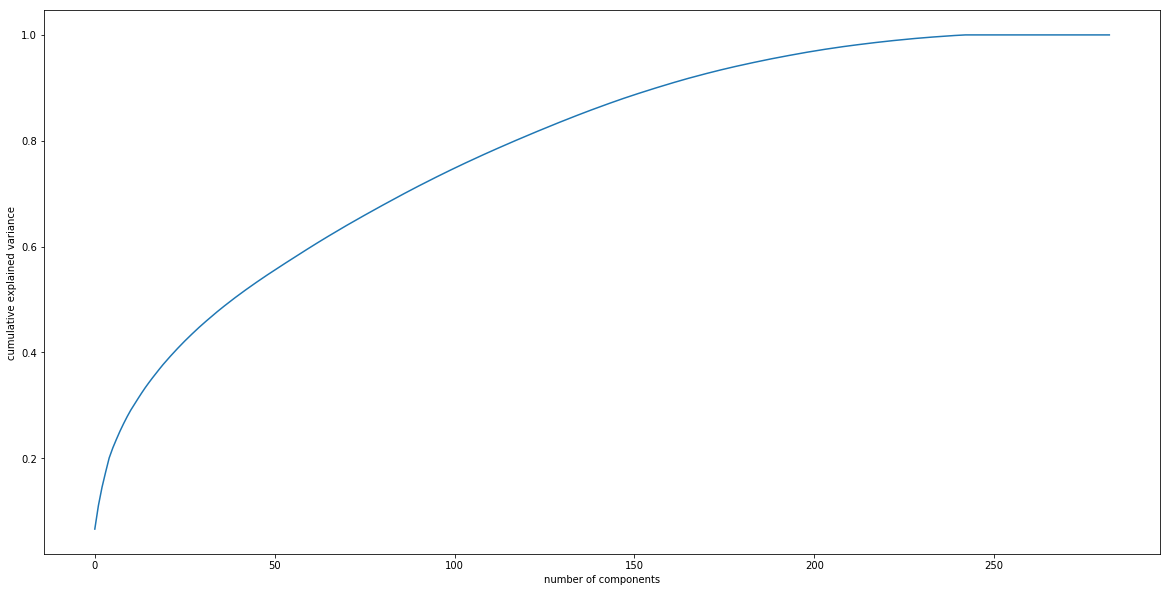

In [14]:
pca = PCA().fit(azdias)
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

### Components from above PCA 

In [15]:
def weights(n):
    """Print the principle components.
    n: Number of principle components
    """
    components = pd.DataFrame(np.round(pca.components_[n-1:n], 4), columns=azdias.keys())
    components.index = ['Weights']
    components = components.sort_values(by = 'Weights', axis = 1, ascending = False)
    components = components.T
    print(components)
    return components

### Now we will reduce the dataset using PCA components to make our data high variance. We will choose 220 components which explains ~90% of the variance 

In [16]:
def reduce_data(df, n=220):
    """Generate reduced dataset using PCA.
    df: Dataset 
    n: Number of components
    """
    pca = PCA(n_components=n).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data

In [17]:
reduced_azdias = reduce_data(azdias)
reduced_customers = reduce_data(customers)

0.986969522593
0.99735816977


In [18]:
reduced_azdias.shape, reduced_customers.shape

((415405, 220), (100341, 220))

### With reduced dimension, now will do clustering and to choose the number of cluster use elbow method.

In [19]:
#def score(data, k):
    
#    kmeans_k = KMeans(k)
#    model_k = kmeans_k.fit(data)
#    return abs(model_k.score(data))
    

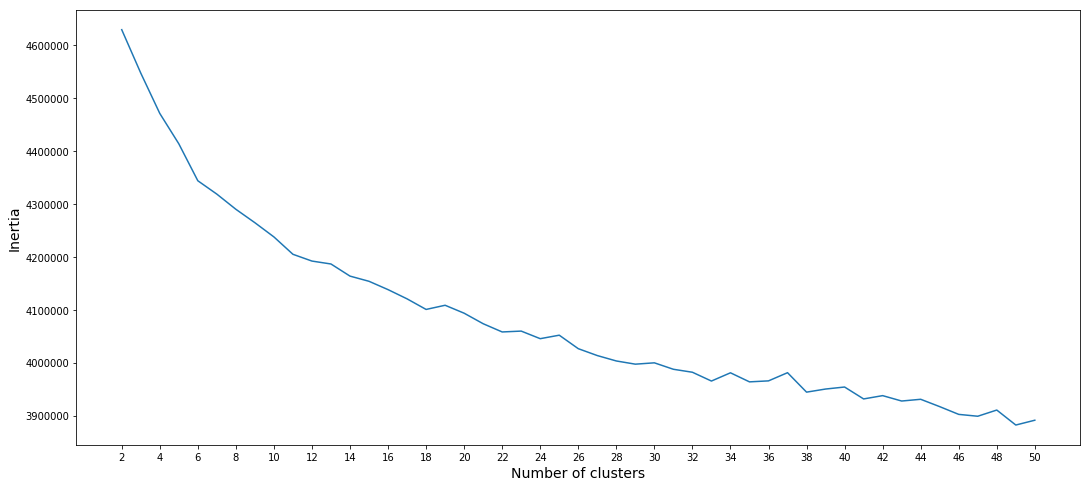

In [20]:
# Compute the inertia
inertias = []

for i in range(2, 51):
    km = KMeans(n_clusters=i, random_state=1000)
    km.fit(reduced_azdias.sample(20000))
    inertias.append(km.inertia_)

# Show the plot inertia vs. no. clusters
fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(np.arange(2, 51, 1), inertias)
ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('Inertia', fontsize=14)
ax.set_xticks(np.arange(2, 51, 2))

plt.show()

In [21]:
kmeans_k = KMeans(12)
model_k = kmeans_k.fit(reduced_azdias)
prediction_azdias = model_k.predict(reduced_azdias)
azdias_clustered = pd.DataFrame(prediction_azdias, columns = ['Cluster'])
azdias_clustered.to_pickle('azdias_clusters')

In [22]:
prediction_customers = model_k.predict(reduced_customers)
customers_clustered = pd.DataFrame(prediction_customers, columns = ['Cluster'])
customers_clustered.to_pickle('customers_clusters')

### Comparison between clusters of general population and customer data

In [23]:
population_clusters = pd.Series(prediction_azdias)
pc = population_clusters.value_counts().sort_index()
customer_clusters = pd.Series(prediction_customers)
cc = customer_clusters.value_counts().sort_index()
df_stat = pd.concat([pc, cc], axis = 1).reset_index()
df_stat.columns = ['cluster', 'population', 'customer']
df_stat['difference'] = (df_stat.customer / df_stat.customer.sum()*100) - (df_stat.population / df_stat.population.sum()*100)
df_stat

,cluster,population,customer,difference
0,0,34402,172,-8.110141
1,1,26325,1048,-5.292751
2,2,31274,46420,38.733689
3,3,12361,4586,1.594765
4,4,42279,2684,-7.502900
5,5,15426,26,-3.687573
6,6,43506,12489,1.973405
7,7,37356,21836,12.769122
8,8,52519,33,-12.609955
9,9,36354,9924,1.138815


### plot the comparison percentage

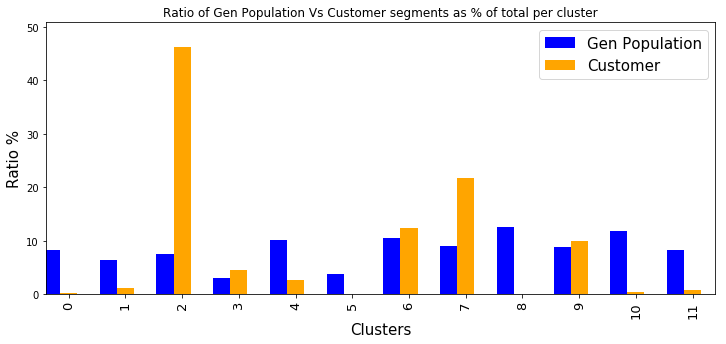

In [24]:
df_stat['pop_percent'] = (df_stat['population']/df_stat['population'].sum()*100).round(2)
df_stat['cust_percent'] = (df_stat['customer']/df_stat['customer'].sum()*100).round(2)


fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(111)
ax = df_stat['pop_percent'].plot(x=df_stat['cluster'],width=-0.3,align='edge',color='blue',kind='bar',position=0)
ax = df_stat['cust_percent'].plot(kind='bar',color='orange',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('Gen Population', 'Customer'),fontsize=15)
plt.title(('Ratio of Gen Population Vs Customer segments as % of total per cluster'))
plt.show()

In [25]:

# Show Highest Positive and Negative weights when a PComponent and Weight is passed
def pca_weights(pc,weight_num):
    
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca.components_, columns = azdias.columns.values)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1,  join_axes=[ratio.index])
    result[:5]
    print("Principal Component: ", (pc))    
    print('\n')
    print("Highest Positive weights:")
    print(result.iloc[(pc)-1].sort_values(ascending=False)[:weight_num])
    print('\n')
    print("Negative weights:")
    print(result.iloc[(pc)-1].sort_values()[:weight_num])

In [26]:
# Show highest positive and negative weights for 5 cluster (over representation of Customer)
pca_weights(5,5)

Principal Component:  5


Highest Positive weights:
KBA13_KMH_210          0.223
OST_WEST_KZ_O          0.187
KBA13_CCM_1401_2500    0.183
KBA13_VORB_0           0.135
KBA13_CCM_2000         0.134
Name: 4, dtype: float64


Negative weights:
KBA13_KW_0_60         -0.239
KBA13_KMH_180         -0.196
KBA13_CCM_0_1400      -0.194
OST_WEST_KZ_W         -0.187
KBA13_SEG_MINIWAGEN   -0.159
Name: 4, dtype: float64


In [27]:
# Show lowest positive and negative weights for 10 cluster (under representation of Customer)
pca_weights(10,5)

Principal Component:  10


Highest Positive weights:
KBA05_MAXSEG     0.272
KBA05_KRSOBER    0.208
KBA05_CCM3       0.186
KBA05_HERST1     0.165
KBA05_KW2        0.163
Name: 9, dtype: float64


Negative weights:
KBA05_CCM1        -0.235
KBA05_MODTEMP     -0.210
KBA05_HERST3      -0.162
OST_WEST_KZ_W     -0.148
KBA05_HERSTTEMP   -0.137
Name: 9, dtype: float64


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [29]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
X = mailout_train.drop('RESPONSE', axis = 1)
y = mailout_train['RESPONSE']

In [31]:
#Preprocess data 
df_mailout_train = data_preprocess(X, False)

shape after corr (42962, 253)
shape after one-hot (42962, 300)
shape after impute (42962, 300)
shape after scaling (42962, 300)


In [32]:
df_mailout_train.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_-1,OST_WEST_KZ_O,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,
-1.656309,1.031262,-0.545883,-0.371726,-0.428455,0.573402,-0.499090,-0.204857,-0.752038,-0.083831,-0.459891,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,-0.494196,0.778419
-1.655987,0.323502,0.396516,0.523127,0.837103,-0.445506,-0.499090,-0.204857,-0.402222,-0.083831,-0.860749,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,-0.494196,0.778419
-1.655785,0.323502,-0.545883,-0.192755,-0.681567,-0.518285,2.042255,-0.204857,-1.101855,-0.083831,-0.059034,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,2.023489,-1.284655
-1.668538,1.031262,-0.545883,-0.729667,-0.934679,-0.227168,-0.499090,-0.204857,-0.402222,-0.083831,-0.059034,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,-0.494196,0.778419
-1.655502,1.031262,-0.545883,-0.192755,-0.175344,3.339007,-0.499090,-0.204857,-0.752038,-0.083831,-0.459891,...,-0.167172,-0.104604,-0.110149,-0.100902,-0.125771,-0.094216,-0.016003,-0.47014,-0.494196,0.778419


In [33]:
# Split dataset 
X_train, X_val, y_train, y_val = train_test_split(df_mailout_train, y, stratify=y, test_size=0.2, random_state=42)

In [34]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)


[18:21:00] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=10, n_jobs=0, num_parallel_tree=1,
       objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
       scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

In [35]:
preds = xg_reg.predict(X_val)
preds

array([ 0.18259767,  0.18259767,  0.18259767, ...,  0.18259767,
        0.18259767,  0.18259767], dtype=float32)

In [36]:
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds)))

ROC score on validation data: 0.5000


In [37]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # TODO: Calculate the training time
    #results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # print('unique predictions_train: ', set(predictions_train))
    
    # TODO: Calculate the total prediction time
    #results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    #results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    #results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    #results['prec_train'] = precision_score(y_train, predictions_train)
    #results['recall_train'] = recall_score(y_train, predictions_train)
    
    #results['prec_test'] = precision_score(y_test, predictions_test)
    #results['recall_test'] = recall_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    #results['f_train'] = fbeta_score(y_train, predictions_train, beta=1)
        
    # TODO: Compute F-score on the test set which is y_test
    #results['f_test'] = fbeta_score(y_test, predictions_test, beta=1)
       
    # Success
    #print("{} trained on samples.".format(learner.__class__.__name__))
    
    #results['roc'] = roc_auc_score(y_test, predictions_test)
    
    roc = roc_auc_score(y_test, predictions_test)
        
    # Return the results
    return roc

In [38]:
# Initialize 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=42)
skf.get_n_splits(X, y)

5

In [39]:
alg_abr = AdaBoostRegressor(random_state=42)
alg_gbr = GradientBoostingRegressor(random_state=42)
alg_xgb = XGBRegressor(random_state=42)


result_list = []
for alg in [alg_abr, alg_gbr, alg_xgb]:
    alg_name = alg.__class__.__name__
    
    
    
    j=0
    for train_index, val_index in skf.split(df_mailout_train, y):
    
        j+=1
        #print('Fold {}...'.format(j))
        result = {}  
        result['alg_name'] = alg_name
        result['fold']  =  j
        # Split the data into training and test sets
        X_train, X_val = df_mailout_train.iloc[train_index], df_mailout_train.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        
        
        result['roc'] = train_predict(alg, X_train, y_train, X_val, y_val)
        result_list.append(result)
        print (result)
    
#return result_list    

#print('result_list: ', result_list)

{'alg_name': 'AdaBoostRegressor', 'fold': 1, 'roc': 0.7520605681485284}
{'alg_name': 'AdaBoostRegressor', 'fold': 2, 'roc': 0.76112332351690848}
{'alg_name': 'AdaBoostRegressor', 'fold': 3, 'roc': 0.78820888122056743}
{'alg_name': 'AdaBoostRegressor', 'fold': 4, 'roc': 0.72870910578577819}
{'alg_name': 'AdaBoostRegressor', 'fold': 5, 'roc': 0.73072796926347061}
{'alg_name': 'GradientBoostingRegressor', 'fold': 1, 'roc': 0.73311512529708089}
{'alg_name': 'GradientBoostingRegressor', 'fold': 2, 'roc': 0.75193446710469802}
{'alg_name': 'GradientBoostingRegressor', 'fold': 3, 'roc': 0.80506516837943964}
{'alg_name': 'GradientBoostingRegressor', 'fold': 4, 'roc': 0.73210648837819448}
{'alg_name': 'GradientBoostingRegressor', 'fold': 5, 'roc': 0.75577588391979689}
{'alg_name': 'XGBRegressor', 'fold': 1, 'roc': 0.5558291721824401}
{'alg_name': 'XGBRegressor', 'fold': 2, 'roc': 0.60636375250274777}
{'alg_name': 'XGBRegressor', 'fold': 3, 'roc': 0.65723789237767871}
{'alg_name': 'XGBRegressor',

In [42]:
df_scores = pd.DataFrame(result_list)
df_scores.groupby('alg_name')['roc'].mean()

alg_name
AdaBoostRegressor            0.752166
GradientBoostingRegressor    0.755599
XGBRegressor                 0.605846
Name: roc, dtype: float64

In [43]:
param ={
            'n_estimators': [500],
            'max_depth':[4],
            'learning_rate':[0.01,0.05,0.1]
        }
# Perform grid search on the classifier using 'scorer' as the scoring method
cv = GridSearchCV(alg_gbr, param, scoring = 'roc_auc', n_jobs= -1, cv=5)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = cv.fit(X_train, y_train)

cv.grid_scores_, cv.best_params_, cv.best_score_

# Get the estimator and predict
best_clf = grid_fit.best_estimator_
#predictions = (best_clf.fit(X_train, y_train)).predict(X_test)

best_predictions = best_clf.predict(X_val)
roc_auc_score(y_val, best_predictions)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


0.76308926133609623

In [44]:
feat_importance = best_clf.feature_importances_
feat_importance

array([  1.07243884e-03,   1.21542964e-04,   3.96407455e-03,
         1.04801598e-02,   2.44717948e-02,   8.31372523e-03,
         1.85264239e-02,   4.50693107e-03,   4.59829465e-03,
         2.84541266e-03,   7.79815788e-04,   1.92281811e-03,
         3.24908983e-03,   5.18550194e-03,   8.45982507e-03,
         3.36776642e-03,   3.41905849e-04,   2.23689209e-03,
         2.47178676e-02,   1.20655648e-03,   3.40388920e-03,
         3.55559854e-03,   3.32201078e-04,   3.14876634e-03,
         2.71058675e-03,   2.25807204e-04,   4.89396455e-03,
         8.62843161e-04,   3.04366494e-03,   9.30106839e-04,
         4.18641341e-07,   3.14651487e-03,   0.00000000e+00,
         2.03103836e-03,   8.73550553e-03,   4.53439191e-03,
         2.39308279e-03,   4.22711435e-03,   1.17434531e-03,
         6.83712808e-04,   0.00000000e+00,   2.37021989e-02,
         1.70533154e-03,   1.19875292e-02,   9.80016737e-04,
         2.22080478e-03,   2.03329784e-03,   1.54057326e-03,
         2.65514706e-03,

['D19_SOZIALES' 'MIN_GEBAEUDEJAHR' 'D19_BANKEN_ANZ_12' 'KBA13_ANZAHL_PKW'
 'ANZ_HAUSHALTE_AKTIV']
[ 0.1199233   0.02891694  0.02471787  0.02452018  0.02447179]


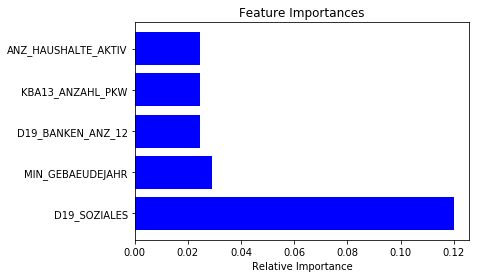

In [46]:
num_feat = 5

indices = np.argsort(feat_importance)[::-1]
columns = X_train.columns.values[indices[:num_feat]]
values = feat_importance[indices][:num_feat]

#print((indices))
print(columns)
print(values)

plt.title('Feature Importances')
plt.barh(np.arange(num_feat), values, color='b', align='center', label = "Feature Weight")
#plt.barh(np.arange(num_feat), np.cumsum(values), color='b', align='center',label = "Cumsum Weight")


plt.yticks(np.arange(num_feat), columns)
plt.xlabel('Relative Importance')
plt.show()

#for name, importance in zip(X_train.column, feat_importance):
#    print(name, "=", importance)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [54]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [55]:
# as we want to make prediction using model trained with mailout_train, check/make sure this dataset is not different
missing = list(np.setdiff1d(mailout_train.columns, mailout_test.columns))
missing

['RESPONSE']

In [56]:
print('before preprocessing mailout_test.shape: ', mailout_test.shape)
mailout_test_clean = data_preprocess(mailout_test, False)
print('after preprocessing mailout_test_clean.shape: ', mailout_test_clean.shape)

before preprocessing mailout_test.shape:  (42833, 366)
shape after corr (42833, 253)
shape after one-hot (42833, 300)
shape after impute (42833, 300)
shape after scaling (42833, 300)
after preprocessing mailout_test_clean.shape:  (42833, 299)


In [57]:
prediction_for_kaggle = best_clf.predict(mailout_test_clean)

In [58]:
df_kaggle = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=prediction_for_kaggle)
df_kaggle.rename(columns={0: "RESPONSE"}, inplace=True)
df_kaggle.head(10)

,RESPONSE
LNR,
1754,0.028279
1770,0.029929
1465,0.006263
1470,0.004441
1478,0.008125
1782,0.002766
1485,0.003115
1519,0.024718
1835,0.023812


In [59]:
df_kaggle.to_csv('submission.csv')